## EDA

In this section, we present an exploratory data analysis of daily returns for BTC, ETH, the S&P 500, the VIX, and Gold. The analysis includes time-series plots of returns, rolling volatility, return distributions, a correlation analysis, pairwise comparisons, and an examination of intraday price ranges. This allows us to compare the volatility and interdependence of cryptocurrencies against traditional assets, as motivated by our research question.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller

# Print current working directory to check location
print("Current working directory:", os.getcwd())

btc_df = pd.read_csv('../data/btc_data.csv', parse_dates=['Date'])
eth_df = pd.read_csv('../data/eth_data.csv', parse_dates=['Date'])
sp500_df = pd.read_csv('../data/sp500_data.csv', parse_dates=['Date'])
vix_df = pd.read_csv('../data/vix_data.csv', parse_dates=['Date'])
gold_df = pd.read_csv('../data/gold_data.csv', parse_dates=['Date'])
btc_df.set_index('Date', inplace=True)
eth_df.set_index('Date', inplace=True)
sp500_df.set_index('Date', inplace=True)
vix_df.set_index('Date', inplace=True)
gold_df.set_index('Date', inplace=True)
#print(btc_df.head())
#print(eth_df.head())
os.makedirs('eda_figures', exist_ok=True)

Current working directory: /Users/bendikwesterheim-hjemas/Downloads/TIO4317_Project_Assignment-main-3/src


# Time series plots of daily returns for each asset

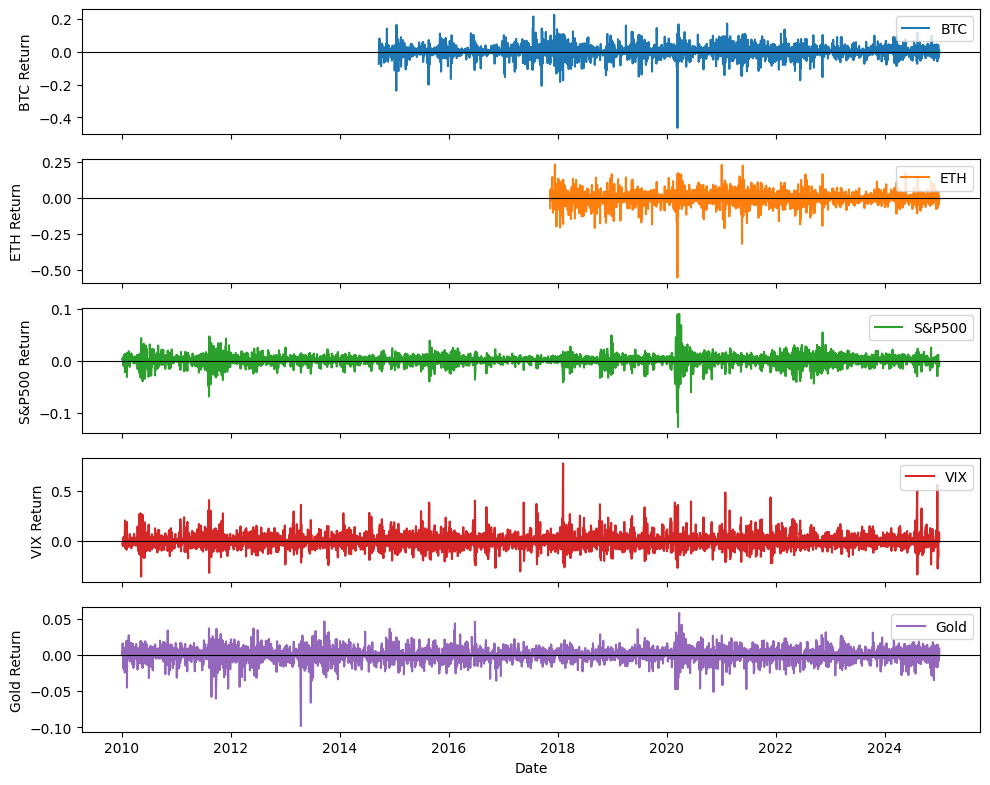

In [2]:
fig, axes = plt.subplots(5, 1, figsize=(10, 8), sharex=True)
assets = {'BTC': btc_df, 'ETH': eth_df, 'S&P500': sp500_df, 'VIX': vix_df, 'Gold': gold_df}
for i, (name, df) in enumerate(assets.items()):
    # If Date is a column, set it as index for plotting (if not already indexed by date)
    if 'Date' in df.columns:
        df = df.set_index('Date')
    axes[i].plot(df.index, df['Return'], label=name, color=f"C{i}")
    axes[i].axhline(0, color='black', linewidth=0.8)  # horizontal line at 0
    axes[i].set_ylabel(f'{name} Return')
    axes[i].legend(loc='upper right')
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.savefig('eda_figures/returns_time_series.png', dpi=300)
plt.show()
plt.close()


As shown in the plot, Bitcoin and Ethereum have visibly higher volatility than the S&P 500, VIX, or Gold. This is quantified in the next plot, which is a 30-day rolling standard deviation for each return series. We see that the rolling volatility of BTC and ETH often spikes to values several times higher than those of the stock index or gold. These findings confirm that crypto assets are far more volatile on a daily basis. 

# Rolling 30-day volatility plots

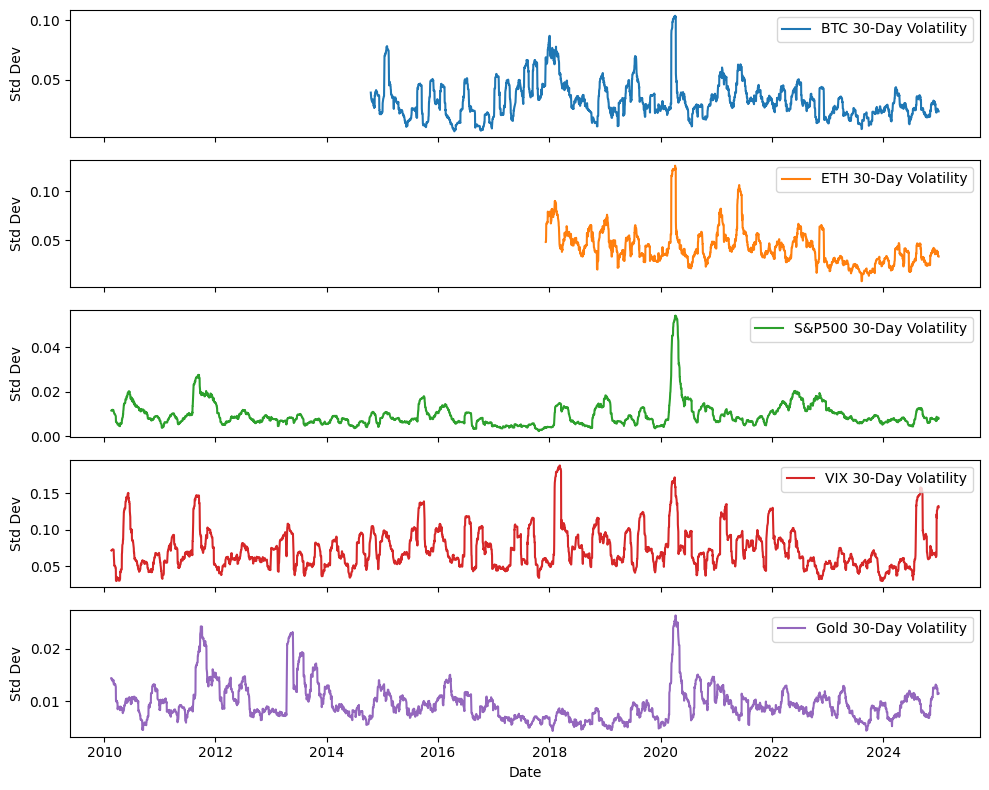

In [3]:
window = 30  # rolling window size (days)
fig, axes = plt.subplots(5, 1, figsize=(10, 8), sharex=True)
for i, (name, df) in enumerate(assets.items()):
    if 'Date' in df.columns:
        df = df.set_index('Date')
    rolling_vol = df['Return'].rolling(window).std()  # 30-day rolling std dev
    axes[i].plot(df.index, rolling_vol, label=f'{name} {window}-Day Volatility', color=f"C{i}")
    axes[i].set_ylabel('Std Dev')
    axes[i].legend(loc='upper right')
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.savefig('eda_figures/rolling_volatility.png', dpi=300)
plt.show()
plt.close()

This plot shows a rolling 30-day volatility for each asset. Higher values indicate more volatile periods. BTC and ETH show significantly higher and more variable volatility over time compared to S&P 500 and Gold. The VIX has distinct spikes during market stress events. Volatility clustering is evident: periods of high volatility tend to persist for some time before reverting to calmer levels (Tsay, 2010, p. 273)

# Histograms and KDE plots of returns distribution

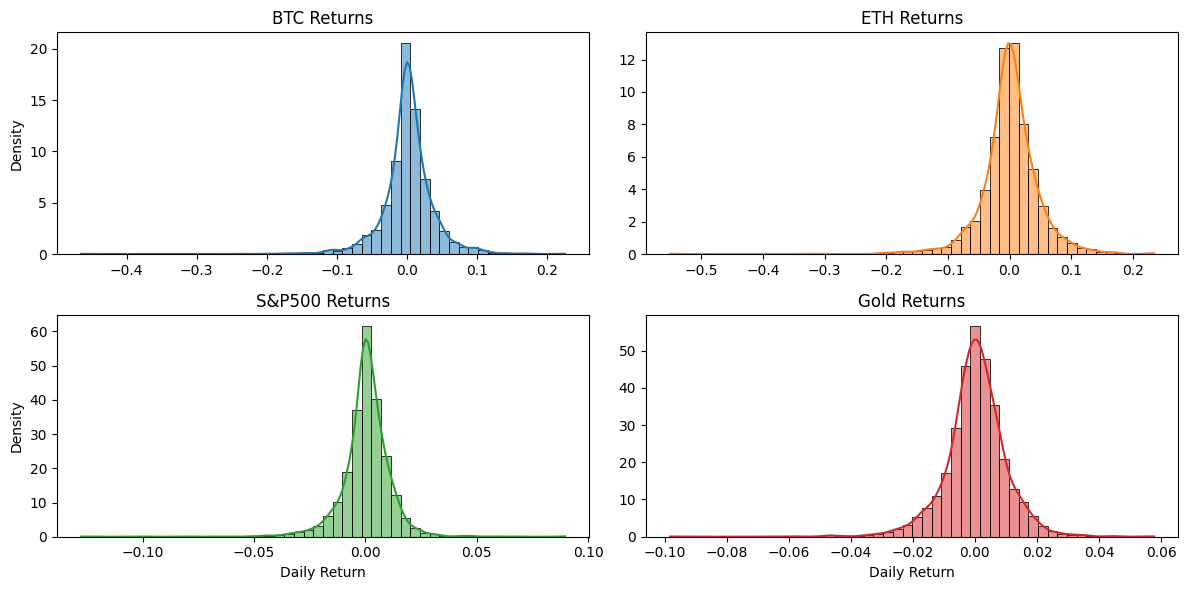

In [4]:
# Exclude VIX from the assets dictionary
filtered_assets = {k: v for k, v in assets.items() if k != 'VIX'}

# Create a 2x2 subplot for the four assets
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
asset_list = list(filtered_assets.items())

for idx, (name, df) in enumerate(asset_list):
    # Get the return series
    if 'Return' in df:
        r = df['Return'].dropna()
    else:
        r = df.dropna()
    
    # Determine subplot position in a 2x2 grid
    ax = axes[idx // 2, idx % 2]
    
    # Plot the histogram with KDE
    sns.histplot(r, kde=True, stat='density', bins=50, ax=ax, color=f"C{idx}")
    ax.set_title(f'{name} Returns')
    
    # Adjust axis labels
    if idx % 2 == 0:
        ax.set_ylabel('Density')
    else:
        ax.set_ylabel('')
        
    if idx // 2 == 1:
        ax.set_xlabel('Daily Return')
    else:
        ax.set_xlabel('')

plt.tight_layout()
plt.savefig('eda_figures/return_distribution.png', dpi=300)
plt.show()
plt.close()


Next, we examine the distribution of returns for each asset. The above plots shows histograms of daily returns with overlaid kernel density estimates (KDE). All assets exhibit a roughly symmetric distribution centered around zero mean, but with fat tails relative to a normal distribution. In particular, BTC and ETH relurns have very wide distributions indicating a higher frequency of both positive and negative. The S&P 500 and Gold returns are more tightly clustered around the mean. Statistically, the sample means of all these return series are close to zero. This is consistent with the idea that asset price changes are unpredictable on average. The return distributions are leptokurtic, showing high kurtosis (peaked center and fat tails). This means there are more extreme outcomes than one would expect under a normal distribution (Tsay, 2010, p. 315). Such fat-tailed behavior implies a higher probability of large losses or gains in cryptos. The distributions are also nearly symmetric with slight skewness. Especially crypto returns show a slight negative skew, indicating a tendency for sudden large drops to occur more often than equally large jumps.


# Correlation matrix and heatmap between the return series

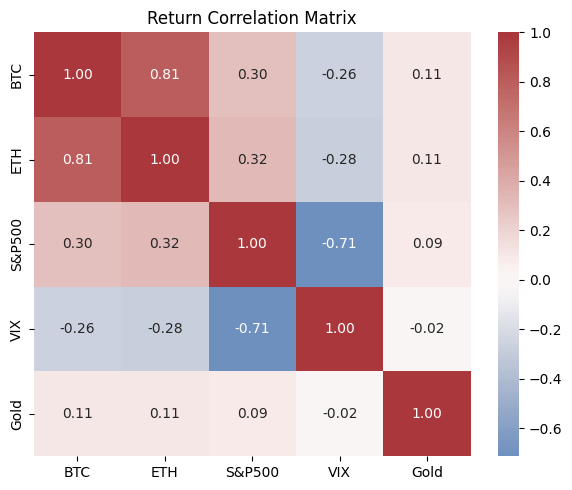

In [5]:
#First, align all return series by date into a single DataFrame
#Since each asset DataFrame already has Date as the index, you can directly reference the 'Return' column:

combined = pd.DataFrame({
    'BTC': assets['BTC']['Return'],
    'ETH': assets['ETH']['Return'],
    'S&P500': assets['S&P500']['Return'],
    'VIX': assets['VIX']['Return'],
    'Gold': assets['Gold']['Return']
})

combined = combined.dropna()  # drop dates where any is NaN (to align the data)
corr_matrix = combined.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="vlag", center=0, fmt=".2f")
plt.title('Return Correlation Matrix')
plt.tight_layout()
plt.savefig('eda_figures/correlation_heatmap.png', dpi=300)
plt.show()
plt.close()

We also analyze the interdependence between these assets. The plot shows a correlation heatmap of the daily returns. We find several insights. BTC and ETH returns are positively correlated with each other since both are cryptocurrencies in the same asset class, whereas their correlations with traditional assets are low. In our sample, BTC and ETH show little correlation with Gold, which is a traditional “safe-haven” asset, and only modest correlation with the S&P 500. This suggests that, historically, cryptocurrencies may offer diversification benefits since their price movements are relatively independent of stock and gold returns on a daily basis. Gold and S&P 500 have a very low or slightly negative correlation, consistent with gold’s role as a diversification asset against equities. As expected, the S&P 500 and VIX are strongly negatively correlated since VIX tends to spike when stock prices plunge. We note that correlations among assets are not static  during periods of market turmoil, asset correlations can change. In fact, it has been observed that correlations between markets tend to increase in a crisis (Tsay, 2010, p. 541). Our analysis only capturess linear correlations over the full sample. Deeper analysis could examine rolling correlations to see how crypto-traditional asset move during stress events.

# Pairwise scatterplots of returns (crypto vs. traditional assets)

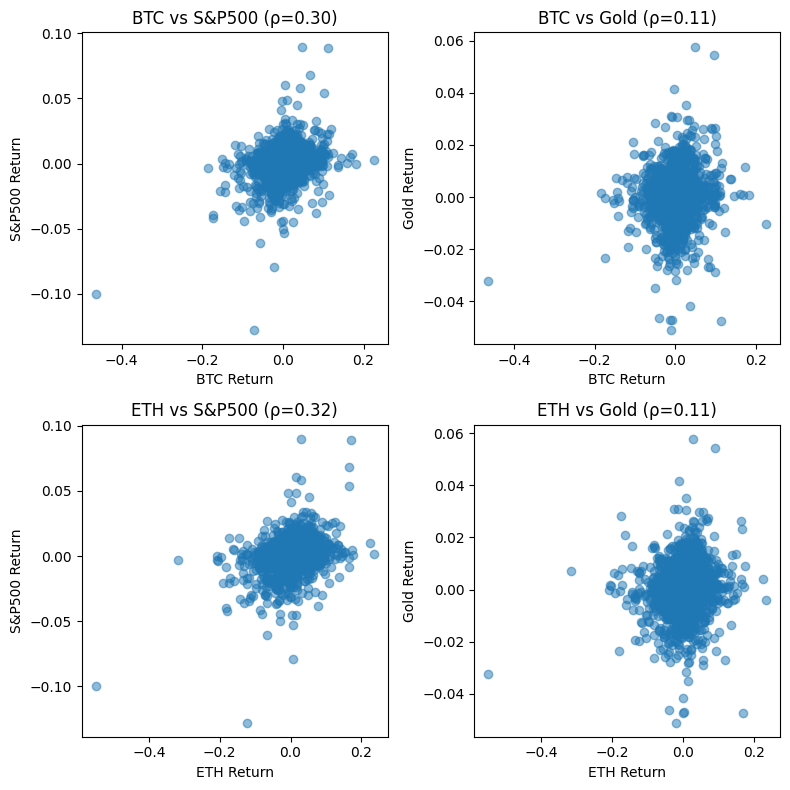

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
pairs = [('BTC', 'S&P500'), ('BTC', 'Gold'), ('ETH', 'S&P500'), ('ETH', 'Gold')]
for ax, (x, y) in zip(axes.flatten(), pairs):
    ax.scatter(combined[x], combined[y], alpha=0.5)
    ax.set_xlabel(f'{x} Return')
    ax.set_ylabel(f'{y} Return')
    # Compute correlation coefficient for annotation (rho)
    rho = combined[x].corr(combined[y])
    ax.set_title(f'{x} vs {y} (ρ={rho:.2f})')
plt.tight_layout()
plt.savefig('eda_figures/crypto_vs_traditional_scatter.png', dpi=300)
plt.show()
plt.close()

The plotted figure complements the correlation analysis by showing pairwise scatter plots of returns for crypto vs. traditional aset pairs. Each subplot plots the daily returns of one cryptocurrency against one traditional asset. We can see that the points are fairly dispersed with no clear linear relationship in the BTC vs S&P 500 and BTC vs Gold plots, reflecting the low correlations mentioned above. Similarly, ETH vs S&P 500 and ETH vs Gold show widely scattered points. There is no strong co-movement pattern, which visually reinforces that crypto returns have largely been independent from equity and gold returns on a day-to-day basis.

# High-Low price spread over time (intraday range)

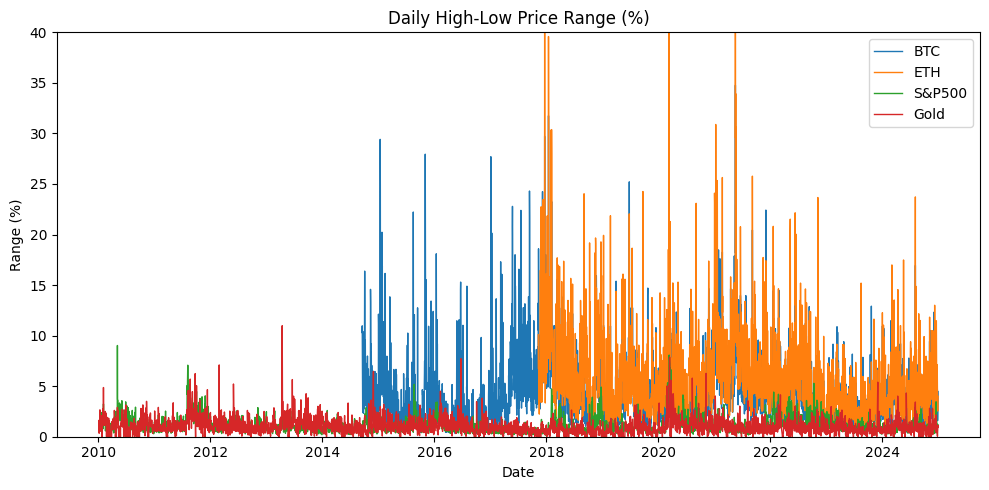

In [7]:
plt.figure(figsize=(10, 5))
for i, (name, df) in enumerate(assets.items()):
    # Calculate daily range (High - Low). Use Close if available for normalization.
    if name == 'VIX':
        continue

    if 'Close' in df.columns:
        spread_pct = (df['High'] - df['Low']) / df['Close'] * 100.0  # percent range
    else:
        spread_pct = (df['High'] - df['Low']) / df['Low'] * 100.0
    if 'Date' in df.columns:
        df_index = df.set_index('Date').index
    else:
        df_index = df.index
    plt.plot(df_index, spread_pct, label=name, linewidth=1.0)
plt.title('Daily High-Low Price Range (%)')
plt.xlabel('Date')
plt.ylabel('Range (%)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.ylim(0, 40)
plt.savefig('eda_figures/high_low_range.png', dpi=300)
plt.show()
plt.close()

We also consider the intraday price range as another measure of volatility. We plot the daily high-low price spread as a percentage of the closing price for each asset over time. This metric captures how volatile each asset is within a single day. Consistent with earlier results, BTC and ETH often have much larger intraday swings (some days the range exceeds 5-10% of price) compared to the S&P 500 or Gold (which typically see less than 2% range on most days). The high-low spread visualization underlines that cryptocurrencies not only move more from day to day, but also exhibit higher volatility within each day. These findings underscore that crypto markets experience extreme fluctuations in short time frames, where traditional markets are relatively more stable intraday. Observing the persistently higher ranges for BTC and ETH further reinforces the need for models that can handle such volatility for instance GARCH-type models, as discussed in Tsay (2010, Ch. 3) for conditional heteroskedasticity.

The EDA shows that cryptocurrencies are far more volatile than traditional financial assets on both an interday and intraday basis. Bitcoin and Ethereum returns have higher standard deviations and more frequent extreme values. All assets show near-zero mean returns and little autocorrelation in returns. We observe volatility clusterings for BTC/ETH which suggests that GARCH-type models (Tsay, 2010, Ch. 3) may be appropriate to capture conditional heteroscedasticity. In terms of interdependence, crypto returns have low correlation with stocks and gold, implying potential diversification benefits. However, one should be cautious because correlations can spike during market crises, meaning crypto and traditional assets might all tumble together under extreme conditions. These insights set the stage for the subsequent modeling and risk analysis, where we will delve deeper into volatility modeling and forecasting using ARCH/GARCH models  and discussing implications for investors.

## ADF

In [8]:
result = adfuller(btc_df['Return'])
print("BTC ADF Statistic: %f" % result[0])
print("BTC p-value: %f" % result[1])

BTC ADF Statistic: -62.559716
BTC p-value: 0.000000
